# Итоговый проект
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- ***data_arc.csv*** — данные об электродах;
- ***data_bulk.csv*** — данные о подаче сыпучих материалов (объём);
- ***data_bulk_time.csv*** — данные о подаче сыпучих материалов (время);
- ***data_gas.csv*** — данные о продувке сплава газом;
- ***data_temp.csv*** — результаты измерения температуры;
- ***data_wire.csv*** — данные о проволочных материалах (объём);
- ***data_wire_time.csv*** — данные о проволочных материалах (время).

Во всех файлах столбец **key** содержит номер партии. В файлах может быть несколько строк с одинаковым значением **key**: они соответствуют разным итерациям обработки.

### Признаки и целевая переменная

Каждая партия имеет уникальный номер (**key**). Этап обработки - период с момента поступления партии в ковш и до получения готового продукта. В ходе обработки над сталью производятся различные действия: добавление примесей, подогрев и другие. Некоторые шаги могут повторяться несколько раз.

Целевым признаком является последняя измеренная температура в данном этапе. При этом в силу особенностей технологического процесса в качестве признака мы можем использовать только первую измеренную температуру, несмотря на то, сколько замеров было сделано на самом деле. Данные обо всех остальных технологических процессах (количество примесей, подогрев, продувка и т.д.) также можно использовать в качестве признаков.

В качестве метрики качества модели используется MAE. Требуется достичь МАЕ не менее 7,8.

# 1. Анализ данных

Импорт необходимых модулей:

In [263]:
import pandas as pd
import os
from time import time
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor, plot_importance

R=1234

Загрузим все таблицы из папки ***final_steel*** и сохраним в соответствующие переменные, а также выведем по несколько записей каждой:

In [264]:
dirname = ('./final_steel/'                        #локально
           if os.path.exists('./final_steel/') 
           else '/datasets/final_steel/')                         #в практикуме

for filename in os.listdir(dirname): 
    if filename.find('.csv') > 0:
        globals()[filename[: -4]] = pd.read_csv(dirname + filename)
        print(f'\nТаблица {filename[: -4]}:')
        display(globals()[filename[: -4]].head(3))


Таблица data_arc:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805



Таблица data_bulk:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0



Таблица data_bulk_time:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40



Таблица data_gas:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793



Таблица data_temp:


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0



Таблица data_wire:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Таблица data_wire_time:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Переведем столбцы с датой и временем в тип *datetime*:

In [265]:
for df in [data_temp, data_arc, data_wire_time, data_bulk_time]:
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_datetime(df[col])

### Изучение этапа обработки
Прежде чем перейти к анализу данных в таблицах, рассмотрим для понимания процесса полный цикл обработки одной партии:

In [266]:
def timeline(key):
    '''Построение таймлайна для партии с номером key'''
    temp = pd.concat(
        [
            data_bulk_time[data_bulk_time['key'] == key].melt(id_vars = 'key').dropna(),
            data_wire_time[data_wire_time['key'] == key].melt(id_vars = 'key').dropna(),
            data_arc[data_arc['key'] == key].melt(id_vars = 'key',
                                                  value_vars = ['Начало нагрева дугой', 'Конец нагрева дугой']),
            data_temp[data_temp['key'] == key].melt(id_vars='key',
                                                    value_vars = 'Время замера')
        ]
    ).sort_values('value').reset_index(drop=True)
    temp.columns = ['Партия', 'Действие', 'Время']
    temp.loc[temp['Действие'] == 'Время замера', 'Действие'] = 'Замер температуры'
    return temp

def highlight(row):         #для выделения цветом
    color = 'white'
    if row.values[1] == 'Замер температуры':
        color = 'lightcoral'
    return ['background-color: ' + color] * 3

timeline(1244).style.apply(highlight, axis=1)

,Партия,Действие,Время
0,1244,Начало нагрева дугой,2019-06-17 08:30:19
1,1244,Конец нагрева дугой,2019-06-17 08:31:31
2,1244,Замер температуры,2019-06-17 08:32:36
3,1244,Wire 1,2019-06-17 08:33:55
4,1244,Замер температуры,2019-06-17 08:39:15
5,1244,Начало нагрева дугой,2019-06-17 08:39:39
6,1244,Конец нагрева дугой,2019-06-17 08:43:19
7,1244,Замер температуры,2019-06-17 08:45:16
8,1244,Bulk 4,2019-06-17 08:49:23
9,1244,Wire 2,2019-06-17 08:49:29


На примере данной партии можно видеть, что подогрев стали, измерение температуры и добавление примесей могут выполняться по несколько раз за этап. Некоторые действия производятся уже после финального замера температуры - соответственно, на целевую переменную они не влияют.

Исследуем данные в загруженных таблицах.

#### data_temp

В ***data_temp*** содержатся результаты измерения температуры в разные моменты времени. Посмотрим информацию о таблице:

In [267]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


В таблице 15907 записей, типы данных - int, float, datetime. В столбце **Температура** присутствуют пропуски.

Изучим столбец **key** (номер партии). Посмотрим на количество партий, а также подсчитаем, сколько раз измерялась температура каждой партии:

Количество партий: 3216


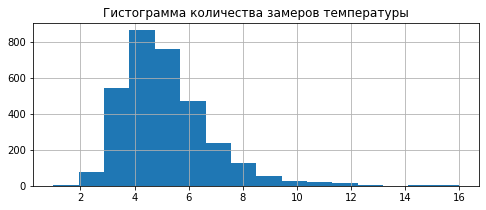

In [268]:
print('Количество партий:', data_temp['key'].nunique())
data_temp['key'].value_counts().hist(bins=16, figsize=(8,3))
plt.title('Гистограмма количества замеров температуры')
plt.show()

Количество партий - 3216, количество замеров температуры - от 1 до 16 раз, в среднем температура измеряется 4-5 раз за этап.

Найдем пропуски в столбце **Температура**:

In [269]:
print(f'Пропусков в столбце Температура: {data_temp["Температура"].isna().sum()}')
data_temp[data_temp['Температура'].isna()]

Пропусков в столбце Температура: 2901


,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Начиная с 2500-ой партии возникли проблемы с сохранением значений температуры. Проверим, есть ли непустые записи после этого момента:

In [270]:
data_temp.query('Температура != "NaN" and key >= 2500').head()

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12271,2501,2019-08-06 03:44:42,1587.0
12276,2502,2019-08-06 04:45:26,1583.0
12283,2503,2019-08-06 05:32:06,1603.0
12287,2504,2019-08-06 06:35:39,1583.0


Получается, что после 2500-ой партии в таблице сохранено только одно (первое) значение температуры для каждой партии, а  последующие показания датчика не фиксировались. Скорее всего это связано с ошибкой записи данных в базу.

Поскольку у этих партий отсутствует финальная температура (целевой признак), для обучения и проверки модели они бесполезны. Удалим их из таблицы:

In [271]:
null_parties = data_temp[data_temp['Температура'].isna()]['key'].unique()
data_temp = data_temp.query('key not in @null_parties')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12267 entries, 0 to 12266
Data columns (total 3 columns):
key             12267 non-null int64
Время замера    12267 non-null datetime64[ns]
Температура     12267 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.3 KB


Изучим распределение значений столбца **Температура**:

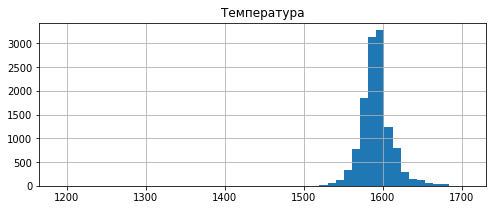

count    12267.000000
mean      1591.999022
std         20.833175
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

In [272]:
data_temp['Температура'].hist(bins = 50, figsize = (8, 3))
plt.title('Температура')
plt.show()
data_temp['Температура'].describe()

Большинство значений нормально распределены в области от 1550 до 1650 градусов, однако есть выбросы со значительно меньшими показателями (менее 1200 градусов). Найдем их:

In [273]:
data_temp[data_temp['Температура'] < 1500]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0


Данные значения неправдоподобны (находятся [ниже температуры плавления стали](http://thermalinfo.ru/svojstva-materialov/metally-i-splavy/temperatura-plavleniya-i-kipeniya-metallov-plotnost-i-teploprovodnost#:~:text=%D0%A2%D0%B5%D0%BC%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D1%83%D1%80%D0%B0%20%D0%BF%D0%BB%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F%20%D1%81%D1%82%D0%B0%D0%BB%D0%B8%20%D0%BD%D0%B0%D1%85%D0%BE%D0%B4%D0%B8%D1%82%D1%81%D1%8F%20%D0%B2%20%D0%B4%D0%B8%D0%B0%D0%BF%D0%B0%D0%B7%D0%BE%D0%BD%D0%B5%20%D0%BE%D1%82%201350%20%D0%B4%D0%BE%201535%C2%B0%D0%A1.)) и, скорее всего, возникли из-за сбоя измерительной аппаратуры. 

Заменим эти значения на медиану столбца:

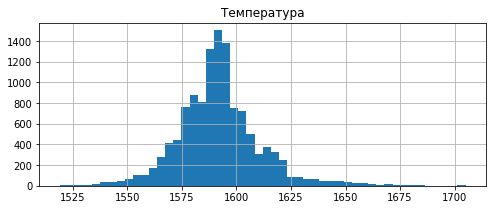

In [274]:
data_temp.loc[data_temp['Температура'] < 1500, 'Температура'] = data_temp['Температура'].median()
data_temp['Температура'].hist(bins = 50, figsize = (8, 3))
plt.title('Температура')
plt.show()

Согласно условию задачи, нас интересуют первая и последняя измеренная температура каждой партии. Найдем нужные значения и сохраним их в новую таблицу ***data_all***:

In [275]:
gr = data_temp.sort_values('Время замера').groupby('key')[['Температура','Время замера']]
data_all = (gr.first().join(gr.last(), rsuffix='_'))
data_all.columns = ['temp_0', 'temp_0_time', 'temp_final', 'temp_final_time']

data_all.head()

,temp_0,temp_0_time,temp_final,temp_final_time
key,,,,
1,1571.0,2019-05-03 11:16:18,1613.0,2019-05-03 11:30:39
2,1581.0,2019-05-03 11:37:27,1602.0,2019-05-03 11:59:12
3,1596.0,2019-05-03 12:13:17,1599.0,2019-05-03 12:34:57
4,1601.0,2019-05-03 12:52:57,1625.0,2019-05-03 12:59:25
5,1576.0,2019-05-03 13:23:19,1602.0,2019-05-03 13:36:01


Найдем партии, у которых температура измерялась только один раз (**temp_0_time** равна **temp_final_time**):

In [276]:
data_all.query('temp_0_time == temp_final_time')

,temp_0,temp_0_time,temp_final,temp_final_time
key,,,,
195,1583.0,2019-05-10 14:10:23,1583.0,2019-05-10 14:10:23
279,1603.0,2019-05-13 23:07:28,1603.0,2019-05-13 23:07:28


Эти записи бесполезны для обучения (в них содержится только целевой признак). Удалим их из таблицы:

In [277]:
data_all = data_all.query('temp_0_time != temp_final_time')
print('Размер выборки:', data_all.shape[0])

Размер выборки: 2475


Рассчитаем для каждой партии время, прошедшее между первым и последним замером температуры - это будет приблизительной оценкой длительности этапа обработки (приблизительной потому, что над сталью могли производится действия до и после измерений):

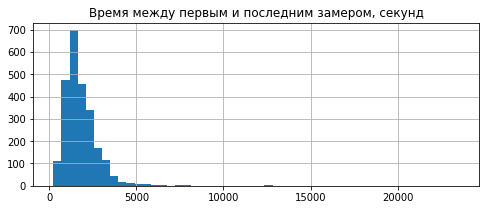

count     2475.000000
mean      1854.953939
std       1301.241764
min        234.000000
25%       1182.500000
50%       1593.000000
75%       2262.500000
max      23537.000000
Name: since_start, dtype: float64

In [278]:
data_all['since_start'] = (data_all['temp_final_time'] - data_all['temp_0_time']).dt.seconds
data_all['since_start'].hist(bins=50, figsize=((8,3)))
plt.title('Время между первым и последним замером, секунд')
plt.show()
data_all['since_start'].describe()

По большей части найденная величина лежит в области от нескольких минут до часа, однако отдельные партии, судя по графику, обрабатывались более 5 часов! Найдем одну из таких партий и посмотрим, в чем дело:

In [279]:
sample_index = data_all.sort_values('since_start', ascending=False).index[0]
data_all.loc[sample_index: sample_index + 3, :]

,temp_0,temp_0_time,temp_final,temp_final_time,since_start
key,,,,,
1689,1583.0,2019-07-02 15:28:21,1606.0,2019-07-02 22:00:38,23537
1690,1598.0,2019-07-02 16:32:13,1588.0,2019-07-02 16:53:24,1271
1691,1583.0,2019-07-02 17:02:23,1587.0,2019-07-02 17:33:30,1867
1692,1568.0,2019-07-02 17:49:19,1591.0,2019-07-02 18:17:34,1695


Итак, обработка партии 1689 начата в 15:28, а завершилась в 22:00, причем за это время через ковш успели пройти еще несколько партий. Очевидно, дело в том, что одной из последующих партий ошибочно был присвоен тот же номер, из-за чего они "слиплись" в базе данных. Возможно и другое объяснение - партия прошла обработку, а спустя некоторое время по каким-то причинам была возвращена обратно для дополнительных действий.

В связи с тем, что запись под номером 1689 (и подобные ей) содержат данные более чем об одном этапе обработки, которые могли проходить по совершенно разным техпроцессам и в разных температурных режимах, для обучения модели они не подходят.

Удалим из таблицы записи с длительностью более 2-х часов:

In [280]:
data_all = data_all.query('since_start < (2 * 60 * 60)')

#### data_arc
Теперь изучим таблицу ***data_arc***. 

In [281]:
display(data_arc.head())
data_arc.info()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


В таблице содержатся данные о подогреве стали электродами (время и мощность). Как и ранее, для каждой партии указано по несколько итераций подогрева.

Взглянем на распределения значений активной и реактивной мощности:

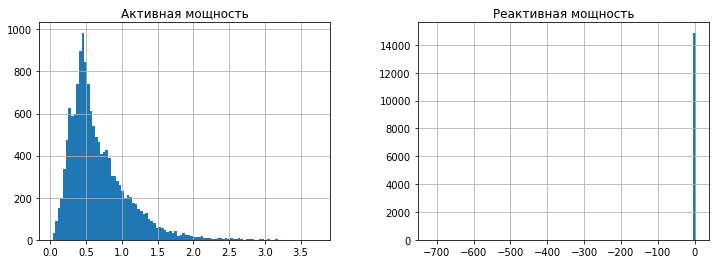

In [282]:
data_arc[['Активная мощность', 'Реактивная мощность']].hist(bins=100, figsize = (12, 4))
plt.show()

Активная мощность вопросов не вызывает, а в гистограмме реактивной мощности присутствует сильный отрицательный выброс. Найдем соответствующую запись:

In [283]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Данное измерение, очевидно, ошибочно. Приравняем реактивную мощность в этой записи к активной и заново построим графики:

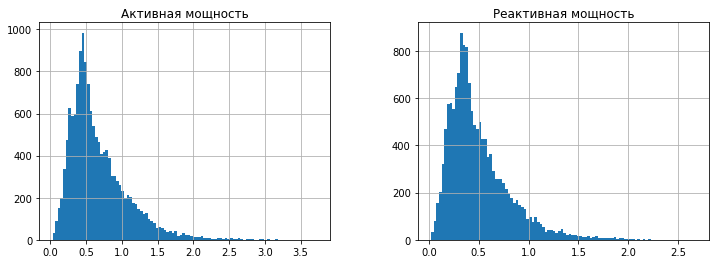

In [284]:
data_arc.loc[9780, 'Реактивная мощность'] = data_arc.loc[9780, 'Активная мощность']
(data_arc[['Активная мощность', 'Реактивная мощность']].hist(bins=100, figsize = (12, 4)))
plt.show()

Теперь все нормально.

Найдем и изучим такую величину, как продолжительность нагрева стали (время от включения до выключения электрода):

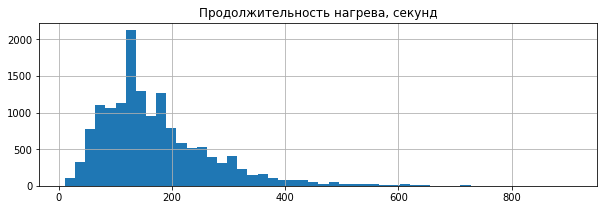

In [285]:
data_arc['Продолжительность нагрева'] = (data_arc['Конец нагрева дугой'] - 
                                         data_arc['Начало нагрева дугой']).dt.seconds

data_arc['Продолжительность нагрева'].hist(bins = 50, figsize = (10,3))
plt.title('Продолжительность нагрева, секунд')
plt.show()

Как можно видеть, стадия подогрева может длиться от нескольких секунд до порядка 15 минут. В данном случае сильных выбросов и недопустимых значений нет.

Рассчитаем для каждой итерации нагрева еще несколько дополнительных параметров:
- полную мощность нагрева (складывается из активной и реактивной мощности по формуле $\sqrt {P_a^2 + P_r^2}$);
- работу, произведенную электродами ($P_a * t_{нагрева}$);
- отношение активной и реактивной мощностей ($P_a / P_r$).

In [286]:
data_arc['Мощность'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** .5
data_arc['Работа'] = data_arc['Активная мощность'] * data_arc['Продолжительность нагрева']
data_arc['Отношение мощностей'] = data_arc['Активная мощность'] / data_arc['Реактивная мощность']
data_arc.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева,Мощность,Работа,Отношение мощностей
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639,222.541395,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010,149.037310,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038,128.030509,1.492292


На основании рассчитаных величин добавим в таблицу с признаками (***data_all***) следующие столбцы:
- суммарное время работы электродов;
- суммарную произведенную работу;
- количество включений электродов;
- среднюю взвешенную мощность;
- среднее взвешенное отношение мощностей.

При этом учтем, что нам нужны только те циклы нагрева, которые произошли до финального замера температуры. Записи о работе электродов, которая произошла после финального замера, уберем из таблицы:

In [287]:
for key in data_all.index:
    data_arc.loc[data_arc['key'] == key, 'temp_final_time'] = data_all.loc[key, 'temp_final_time']
    
data_arc = data_arc.loc[data_arc['Начало нагрева дугой'] < data_arc['temp_final_time']]
print('Осталось записей:', data_arc.shape[0])

Осталось записей: 11133


Наконец, добавим вышеуказанные значения в общую таблицу:

In [288]:
data_arc['p_t'] = data_arc['Отношение мощностей'] * data_arc['Продолжительность нагрева'] #для расчета среднего взвешенного

data_all[['heating_count',  
          'heating_duration', 
          'total_work']] = data_arc.pivot_table(index='key', aggfunc={'Начало нагрева дугой': 'count',
                                                                'Продолжительность нагрева':'sum',
                                                                'Работа': 'sum',
                                                         })
data_all['power_mean'] = data_all['total_work'] / data_all['heating_duration']
data_all['power_ratio_mean'] = data_arc.groupby('key')['p_t'].sum() / data_all['heating_duration']
data_all.head(3)

,temp_0,temp_0_time,temp_final,temp_final_time,since_start,heating_count,heating_duration,total_work,power_mean,power_ratio_mean
key,,,,,,,,,,
1,1571.0,2019-05-03 11:16:18,1613.0,2019-05-03 11:30:39,861,5,1098,1207.804249,1.100004,1.534047
2,1581.0,2019-05-03 11:37:27,1602.0,2019-05-03 11:59:12,1305,4,811,733.816470,0.904829,1.530791
3,1596.0,2019-05-03 12:13:17,1599.0,2019-05-03 12:34:57,1300,5,655,443.583327,0.677226,1.579815


#### data_gas

Изучим таблицу ***data_gas***:

In [289]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В таблице 3239 записей. При этом похоже, что каждая партия подвергалась продуву только один раз. Проверим это: посмотрим, есть ли дубликаты в столбце **key**:

In [290]:
print('Дубликатов', data_gas['key'].duplicated().sum())

Дубликатов 0


Изучим значения столбца **Газ 1**:

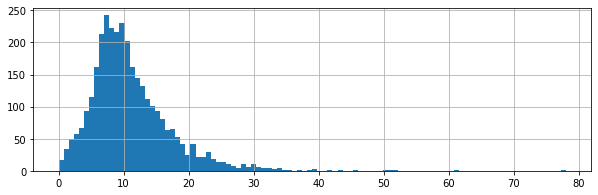

In [291]:
data_gas['Газ 1'].hist(bins = 100, figsize = (10,3))
plt.show()

Видим нормальное распределение с большинством значений в области от 0 до 20, а также несколько выбросов вплоть до 70 - 80. Поскольку мы не знаем, что за величина указана в столбце **Газ 1**, заключений о возможности и допустимости выбросов делать нельзя.

Добавим информацию о продувке газом в нашу таблицу с признаками (***data_all***)

In [292]:
data_all['gas'] = data_gas.set_index('key')

#### data_bulk, data_bulk_time

В данных таблицах указаны, соответственно, объемы и время добавления в сталь сыпучих примесей:

In [293]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [294]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null datetime64[ns]
Bulk 2     22 non-null datetime64[ns]
Bulk 3     1298 non-null datetime64[ns]
Bulk 4     1014 non-null datetime64[ns]
Bulk 5     77 non-null datetime64[ns]
Bulk 6     576 non-null datetime64[ns]
Bulk 7     25 non-null datetime64[ns]
Bulk 8     1 non-null datetime64[ns]
Bulk 9     19 non-null datetime64[ns]
Bulk 10    176 non-null datetime64[ns]
Bulk 11    177 non-null datetime64[ns]
Bulk 12    2450 non-null datetime64[ns]
Bulk 13    18 non-null datetime64[ns]
Bulk 14    2806 non-null datetime64[ns]
Bulk 15    2248 non-null datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


Данные таблицы, в отличие от предыдущих, имеют "широкий" формат. Для каждой партии в столбцах **Bulk 1** - **Bulk 15** указаны объем и время добавления соответствующей примеси.

Проверим, есть ли несоответствия в этих двух таблицах (например, для определенной примеси указан объем, но отсутствует время добавления):

In [295]:
print('Расхождений в таблицах:', 
      ((data_bulk.isna() ^ data_bulk_time.isna()) # =0, если соответствующие ячейки обе пусты или обе не пусты
      .sum().sum()))                              #суммируем по строкам и столбцам

Расхождений в таблицах: 0


Построим гистограммы для различных примесей:

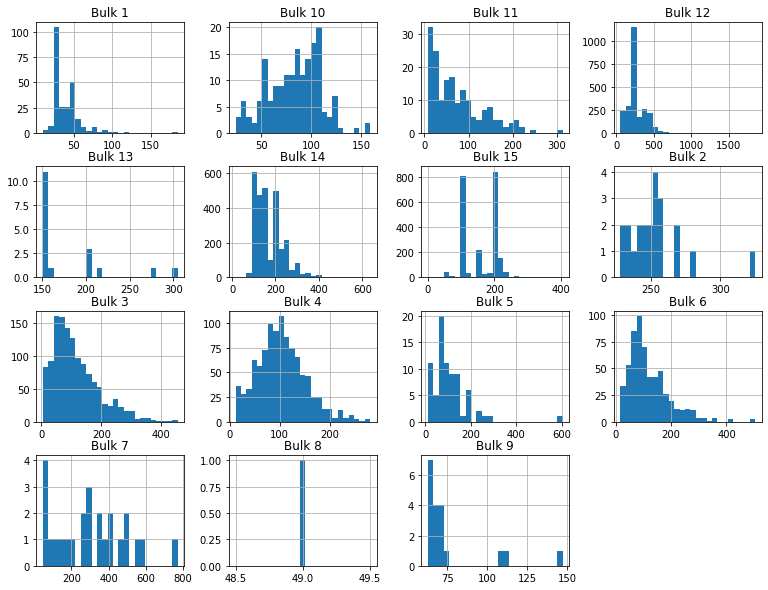

In [296]:
data_bulk.set_index('key', inplace=True)          #установим key в качестве индекса
data_bulk_time.set_index('key', inplace=True)

data_bulk.hist(bins = 25, figsize = (13, 10))
plt.show()

Гистограммы получились разнообразными по форме, что ожидаемо - для получения различных сортов стали нужны разные примеси и в разных количествах. Гребенчатый вид некоторых графиков объясняется либо малым количеством записей, либо технологическим процессом, который предусматривает добавление точных количеств примеси.

Прежде чем добавить данные в таблицу с признаками, нужно убрать из информацию о примесях, которые были добавлены в сталь после последнего замера температуры: 

In [297]:
data_bulk_time['final_time'] = data_all['temp_final_time'] #добавим столбец со временем финального замера t для партии
for column in data_bulk_time.columns[:-1]:
    data_bulk_time[column] = data_bulk_time[column] <= data_bulk_time['final_time']
    
data_bulk = data_bulk.where(data_bulk_time, 0)             #занулим пропуски и примеси, добавленные позже
data_bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


В результирующей таблице большая часть ячеек - нули. Посмотрим, сколько ненулевых значений в каждом столбце:

In [298]:
value_count = (data_bulk != 0).sum()
value_count

Bulk 1      195
Bulk 2        9
Bulk 3      955
Bulk 4      803
Bulk 5       49
Bulk 6      434
Bulk 7       11
Bulk 8        1
Bulk 9       13
Bulk 10     141
Bulk 11     126
Bulk 12    1868
Bulk 13      11
Bulk 14    2123
Bulk 15    1698
dtype: int64

Как видим, в некоторых столбцах заполнено всего несколько десятков значений (тогда как записей в таблице около 3000). Такие признаки вредны для обучения, так как ухудшат обобщающую способность модели, поэтому их следует исключить из рассмотрения. 

Оставим в таблице только те столбцы, которые имеют более ста ненулевых значений:

In [299]:
data_bulk = data_bulk[value_count[value_count > 100].index]

Добавим информацию о примесях в общую таблицу:

In [300]:
data_all = data_all.join(data_bulk)

#### data_wire
Аналогичным образом изучим данные по легированию подачей проволоки:

In [301]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [302]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null datetime64[ns]
Wire 2    1079 non-null datetime64[ns]
Wire 3    63 non-null datetime64[ns]
Wire 4    14 non-null datetime64[ns]
Wire 5    1 non-null datetime64[ns]
Wire 6    73 non-null datetime64[ns]
Wire 7    11 non-null datetime64[ns]
Wire 8    19 non-null datetime64[ns]
Wire 9    29 non-null datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [303]:
print('Расхождений в таблицах:', 
      ((data_wire.isna() ^ data_wire_time.isna()) 
      .sum().sum()))  

Расхождений в таблицах: 0


Построим гистограммы для каждого столбца:

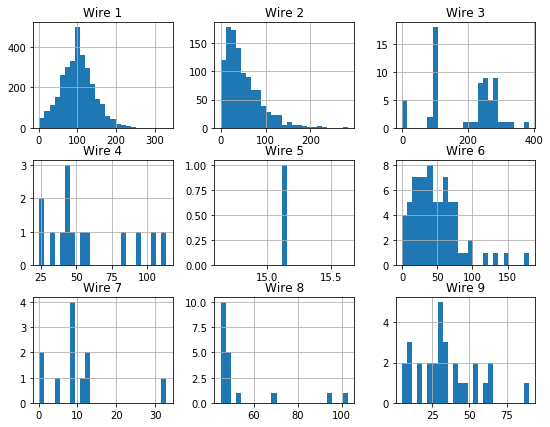

In [304]:
data_wire.set_index('key', inplace=True)
data_wire_time.set_index('key', inplace=True)
data_wire.hist(bins = 25, figsize = (9, 7))
plt.show()

Как и в прошлом случае, исключим примеси, добавленные после финального замера температуры:

In [305]:
data_wire_time['final_time'] = data_all['temp_final_time'] 
for column in data_wire_time.columns[:-1]:
    data_wire_time[column] = data_wire_time[column] <= data_wire_time['final_time']
data_wire = data_wire.where(data_wire_time, 0)

Как и в случае с таблицей ***data_bulk***, исключим из рассмотрения примеси, присутствующие менее чем в 100 партиях:

In [306]:
value_count = (data_wire != 0).sum()
data_wire = data_wire[value_count[value_count > 100].index]

Добавим данные в общую таблицу:

In [307]:
data_all = data_all.join(data_wire)

# 2. Подготовка признаков

В итоге у нас получилась такая таблица признаков:

In [308]:
data_all = data_all.drop(columns=['temp_0_time', 'temp_final_time']).fillna(0) # эти столбцы больше не нужны

display(data_all.head(5), data_all.shape)

,temp_0,temp_final,since_start,heating_count,heating_duration,total_work,power_mean,power_ratio_mean,gas,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
key,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861,5,1098,1207.804249,1.100004,1.534047,29.749986,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000
2,1581.0,1602.0,1305,4,811,733.816470,0.904829,1.530791,12.555561,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000
3,1596.0,1599.0,1300,5,655,443.583327,0.677226,1.579815,28.554793,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000
4,1601.0,1625.0,388,4,741,670.663327,0.905079,1.561254,18.841219,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000
5,1576.0,1602.0,762,4,869,997.496095,1.147867,1.488775,5.413692,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456


(2456, 20)

Для обучения доступно 2456 примеров, каждый из которых содержит 19 признаков (не считая целевого).

Выделим целевой признак в переменную ***target***, а остальные - в переменную ***features***:

In [309]:
features = data_all.drop(columns = ['temp_final'])
target = data_all['temp_final']

Разобьем набор данных на обучающую, валидационную и проверочную подвыборки в соотношении 3:1:1.

In [310]:
tr_and_val_feats, test_feats, tr_and_val_target, test_target = train_test_split(features, target,
                                                                                train_size = 0.8,   # 4:1
                                                                                random_state = R)
train_feats, valid_feats, train_target, valid_target = train_test_split(tr_and_val_feats, 
                                                                        tr_and_val_target,
                                                                        train_size = 0.75,          # 3:1
                                                                        random_state = R)

print(f'''Размеры выборок:

Обучающая \t {train_feats.shape[0]}
Валидационная \t {valid_feats.shape[0]}
Тестовая \t {test_feats.shape[0]}''')

Размеры выборок:

Обучающая 	 1473
Валидационная 	 491
Тестовая 	 492


# 3. Построение модели

Для решения нашей задачи предлагается рассмотреть следующие алгоритмы машинного обучения:
- Линейная регрессия;
- Случайный лес;
- Градиентный бустинг.
    
### Линейная регрессия

Построим модель линейной регрессии, обучим ее на обучающих данных и найдем метрику качества на валидационном наборе:

In [311]:
def model_quick_test(model, name):
    '''Обучение модели на train и нахождение MAE на valid'''
    t_0 = time()
    model.fit(train_feats, train_target)
    t_fit = time() - t_0
    train_pred = model.predict(train_feats)
    train_mae = mean_absolute_error(train_pred, train_target)
    valid_pred = model.predict(valid_feats)
    valid_mae = mean_absolute_error(valid_pred, valid_target)
    print(f'Модель: {name}' +
          f'\nMAE на тренировочных данных: {round(train_mae, 4)}' +
          f'\nMAE на валидационных данных: {round(valid_mae, 4)}' +
          f'\nВремя обучения: {round(t_fit, 4)} с.')

model_quick_test(LinearRegression(), 'Линейная регрессия')

Модель: Линейная регрессия
MAE на тренировочных данных: 6.5261
MAE на валидационных данных: 6.6067
Время обучения: 0.002 с.


Получили неплохой результат - 6.6. Линейную регрессию будем использовать в качестве проверки остальных моделей "на вменяемость" - их результаты должны быть не хуже.

### Случайный лес

Теперь построим модель случайного леса (с гиперпараметрами по умолчанию):

In [312]:
model_quick_test(RandomForestRegressor(100), 'Случайный лес')

Модель: Случайный лес
MAE на тренировочных данных: 2.2487
MAE на валидационных данных: 6.2448
Время обучения: 1.0924 с.


Для случайного леса получили MAE на валидации ~ 6.2. Попробуем улучить качество, подобрав оптимальные гиперпараметры с помощью поиска по сетке. При этом, поскольку в GridSearchCV используется кросс-валидация, обучать его можно на объединенном обучающем и валидационном датасете:

In [328]:
SKIP_GRID_SEARCH = True                                      # для экономии времени опускаем поиск по сетке

if SKIP_GRID_SEARCH:                                        
    parameters = {'n_estimators': [200], 'max_depth': [25]}
else:                                                       
    parameters = {'n_estimators': range(50, 201, 25),
                  'max_depth': range(10, 31, 5)
                  }

grid = GridSearchCV(estimator = RandomForestRegressor(random_state = R),
                    param_grid = parameters,
                    scoring = 'neg_mean_absolute_error',
                    cv = 5,
                    verbose = False,
                    n_jobs=-1)

grid.fit(tr_and_val_feats, tr_and_val_target)

print(f'Оптимальными параметрами для RandomForestClassifier являются {grid.best_params_}' +
      f'\nСредняя МАЕ: {-round(grid.best_score_, 4)}')

Оптимальными параметрами для RandomForestClassifier являются {'max_depth': 25, 'n_estimators': 200}
Средняя МАЕ: 6.0684


После подбора параметров нам удалось еще улучшить МАЕ, снизив ее до 6,06.

### Градиентный бустинг

Для построения модели градиентного бустинга воспользуемся библиотекой LightGBM. Гиперпараметры пока оставим по умолчанию:

In [314]:
model_quick_test(LGBMRegressor(random_state=R), 'Градиентный бустинг')

Модель: Градиентный бустинг
MAE на тренировочных данных: 2.1094
MAE на валидационных данных: 5.865
Время обучения: 0.1402 с.


Градиентный бустинг даже без дополнительных настроек превзошел рассмотренные ранее модели и показал на валидации МАЕ менее 6.
Подберем для него оптимальные параметры с помощью GridSearchCV:

In [327]:
SKIP_GRID_SEARCH = True                                      # для экономии времени опускаем поиск по сетке

if SKIP_GRID_SEARCH: 
    parameters = {'max_depth': [-1], 'learning_rate': [0.1], 'n_estimators': [100]}
else:
    parameters = {'max_depth': [-1, 3, 5, 8],
                  'learning_rate': [0.01, 0.05, 0.1, 0.5],
                  'n_estimators': range(40, 101, 20)
                  }

grid = GridSearchCV(estimator = LGBMRegressor(random_state=R),
                    param_grid = parameters,
                    scoring = 'neg_mean_absolute_error',
                    cv = 5,
                    verbose = False,
                    n_jobs=-1)

grid.fit(tr_and_val_feats, tr_and_val_target)

print(f'Оптимальными параметрами для LGBMRegressor являются {grid.best_params_}' +
      f'\nСредняя МАЕ: {-round(grid.best_score_, 4)}')

Оптимальными параметрами для LGBMRegressor являются {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100}
Средняя МАЕ: 5.7961


C помощью подбора гиперпараметров нам удалось еще немного улучшить метрику качества.

# 4. Проверка модели на тестовом наборе
Наилучший результат в предыдущем шаге показал градиентный бустинг. Построим модель с найденными оптимальными гиперпараметрами и проверим ее качество на тестовой выборке:

In [324]:
t_0 = time()
model = LGBMRegressor(**grid.best_params_, random_state=R)
model.fit(tr_and_val_feats, tr_and_val_target)
t_fit = time() - t_0
test_pred = model.predict(test_feats)
test_rmse = mean_absolute_error(test_pred, test_target)
print('Результаты:\n',
     f'MAE на тестовых данных: {round(test_rmse, 4)},\n',
     f'время обучения: {round(t_fit, 4)} с.')

Результаты:
 MAE на тестовых данных: 5.3639,
 время обучения: 0.1704 с.


Итоговый результат для выбранной нами модели: МАЕ = 5.3639

Посмотрим, какие из признаков оказались наиболее важными для предсказания температуры:

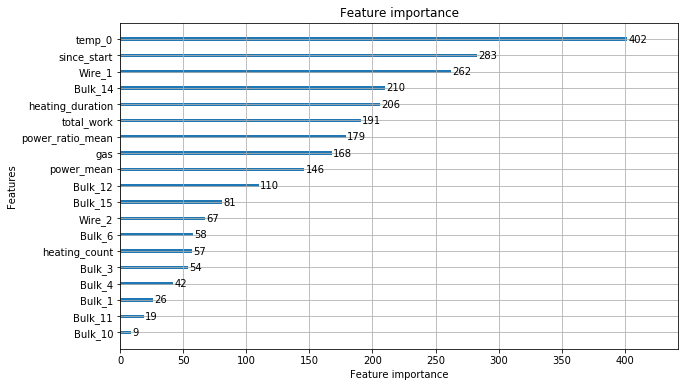

In [317]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax)
plt.show()

Как видно из графика, наибольшее значение имеет начальная температура стали (что вполне логично), а также продолжительность этапа и суммарная работа, произведенная нагревателями. Также довольно большое значение имеет объем добавленных примесей Wire 1 и Bulk 14 - возможно, они влияют на теплопроводность стали.

# 5. Отчет по решению

В данной работе от нас требовалось построить модель регрессии, которая предсказывает температуру стали в конце этапа обработки. Готовая модель должна показывать на тестовом наборе МАЕ не менее 8.7.

Для выполнения задания нами сделаны следующие шаги:

***1. Анализ и предобработка входных данных.***

 В ходе изучения данных мы преобразовали их в нужный тип, избавились от пропусков и недопустимых значений. При этом были обнаружены следующие проблемы:
 - для ряда партий (начиная с 2500-ой и до конца датасета) в таблице ***data_temp*** сохранены только результаты первого замера температуры. Вероятно, это вызвано ошибкой записи в базу данных. Соответствующие записи были удалены из датасета, поскольку в них отсутствует целевой признак;
 - были обнаружены партии, обработка которых длилась аномально долго. Проанализировав эти записи, мы сделали вывод, что нескольким разным партиям был присвоен один и тот же номер, из-за чего они "слиплись" в таблице. Такие записи так же было решено удалить.

***2. Создание и отбор признаков.***

В качестве признаков мы использовали 
 - начальную температуру стали;
 - продолжительность этапа обработки (время между первым и последним замером);
 - рассчитанные нами показатели работы нагревательных электродов (время нагрева, среднюю мощность и некоторые другие прочие);
 - данные о продувке стали газом;
 - объем добавленных примесей.

Поскольку некоторые примеси используются очень редко, они были исключены из рассмотрения как шум.

***3. Выбор модели.***

Для решения нашей задачи мы попробовали следующие модели регрессии:
 - **Линейная регрессия** (sklearn.linear_model.LinearRegerssion). Полученная МАЕ на валидационном наборе - 6.61;
 - **Случайный лес** (sklearn..ensemble.RandomForestRegressor). После подбора гиперпараметров средняя МАЕ на кросс-валидации - 6.07;
 - **Градиентный бустинг** (lightgbm.LGBMRegressor(). Для модели с гиперпараметрами по умолчанию МАЕ на валидации составила 5.87; после подбора гиперпараметров с помощью поиска по сетке средняя МАЕ на кросс-валидации составила 5.79.
 
Все модели показали хороший результат и уложились в требуемую метрику. Наилучшей же моделью стал LGBMRegressor с параметрами: *n_estimators* - 100, *learning_rate* - 0.1, остальные по умолчанию.

Наиболее важными параметрами для регрессора оказались: начальная температура стали, продолжительность этапа, время нагрева, совершенная электродами работа, а также объем добавленных примесей Wire 1 и Bulk 14.

***4. Проверка модели***

Выбранная модель была заново обучена и проверена на тестовом наборе. Результирующая МАЕ составила **5.3639**.